# SciPy Minimize

## Multidimensional Methods

* [Output Object](#output)
* [`args` and Function Parameters](#args)
* [Gradients](#gradients)
* [Hessians](#hessians)
* [Routine Comparison](#routine_comparison)
* [Bounds and Constraints](#bounds_constraints)
    * [Bounds](#bounds)
    * [Linear Constraints for `trust-constr`](#linear_trustconstr)
    * [Non-linear Constraints for `trust-constr`](#nonlinear_trustconstr)
    * [Constraints in `SLSQP`](#constraint_SLSQP)

In [1]:
# Importing the packages for the example
import numpy as np
import scipy.optimize as optimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

### Function Form

The routine `minimize` optimizes over an array variable.  Each component of the array represents a dimension.  Any additional function variables are parameters that can be passed via the flag `args=` to the routine.

$$
\text{min}_{\vec{x} \in U} f(\vec{x}| a, ...) 
$$

$$
f(\vec{x}) = x_0^2 + x_1^2 + x_0 x_1
$$

In [2]:
# Simplest test function
f = lambda x : x[0]**2 + x[1]**2 + x[0]*x[1]

In [79]:
result=optimize.minimize(f,[1,1])
print(result)

      fun: 1.5869182200826406e-16
 hess_inv: array([[ 0.66666667, -0.33333333],
       [-0.33333333,  0.66666667]])
      jac: array([-6.91799246e-09, -6.91799246e-09])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([-7.27305122e-09, -7.27305122e-09])


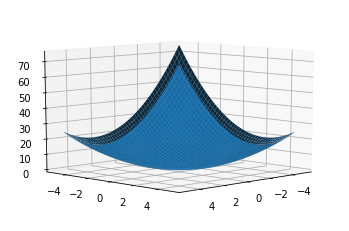

In [60]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x0_a, x1_a, f([x0_a,x1_a]))
ax.view_init(10, 45)

plt.show()

Notes for me:

Is the surface plot more intuitive? Think so, I should probably switch, but I'm going to leave that choice for later...

Text(0, 0.5, 'x[1]')

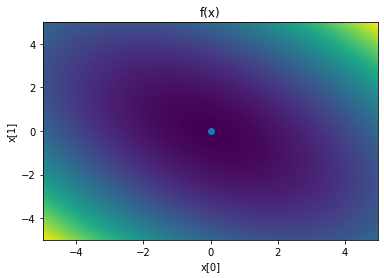

In [64]:
# Coordinates for plotting
x0 = np.arange(-5,5,.01)
x1 = np.arange(-5,5,.01)
# creating 2D array
x0_a, x1_a = np.meshgrid(x0,x1)

# plotting our test functions
fig, ax = plt.subplots()
ax.pcolor(x0_a,x1_a,f([x0_a,x1_a]))
ax.scatter(result.x[0],result.x[1])
ax.set_title('f(x)')
ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')

<div id="output" />

### Output Object

Minimize outputs a custom object, `OptimizeResult`, which is based on a Python dictionary.  

Though it has some standard outputs, each method can return different information.  

Availible data can be accessed by

In [5]:
result.keys()

dict_keys(['fun', 'jac', 'hess_inv', 'nfev', 'njev', 'status', 'success', 'message', 'x', 'nit'])

And each attribute can be accessed as:

In [6]:
result.x

array([-7.27305122e-09, -7.27305122e-09])

<div id="args" />

### `args` and function parameters

For a function with parameters and extra variables, the `args` parameter passes that variable to the function.

For example, if we add a parameter `a` that shifts the location of the minimum in the `x[1]` direction:

In [8]:
# Test function that uses a parameter a
f_parameter = lambda x , a: x[0]**2 + (x[1]-a)**2 + x[0]*(x[1]-a)

Then then we can pass any valid variable to to `args` at run time:

In [20]:
result_parameter2 = optimize.minimize(f_parameter,[1,1],args=(2))
result_parameter3 = optimize.minimize(f_parameter,[1,1],args=(3))
print("Minimum Location a=2: ",result_parameter2.x)
print("Minimum Location a=3: ",result_parameter3.x)

Minimum Location a=2:  [-6.46465798e-09  2.00000000e+00]
Minimum Location a=3:  [-1.24749874e-06  3.00000100e+00]


<div id="gradients" />

### Gradients
<hr>
Derivatives can be supplied to:

* CG
* BFGS
* Newton-CG
* L-BFGS-B
* TNC
* SLSQP
* dogleg
* truct-ncg
* trust-krylov
* trust-exact
* trust-constr

Can check if the algorithm used gradients in the calculation if the result has the key `jac`.

Sanity check on optimization if jacobian of final answer is 0 in unbounded answer.  If bounded problem's answer is not zero, then bounds matter.

If we can analytically calculate the gradient, we can pass that to the algorithm for it to use.  

First write a function to return a numpy array, like:

In [14]:
def df (x):
    df_dx0 = 2*x[0] + x[1]
    df_dx1 = 2*x[1] + x[0]
    return np.array([df_dx0, df_dx1])

Then we can pass that to the solver via the `jac`, jacobian, flag:

In [82]:
result_jac = optimize.minimize(f,[1,1],jac=df)
print(result_jac.message,"\t",result_jac.jac)

Optimization terminated successfully. 	 [3.33066907e-16 3.33066907e-16]


We could also define a routine that returns the function and it's derivative at the same time.

This could be efficient if both repeat many of the same computations:

In [19]:
def f_jac_together (x):
    return f(x),df(x)

When `jac` flag recieves the Boolean `True`, `minimize` knows to look for the derivative with the function:

In [29]:
result_jac_together = optimize.minimize(f_jac_together,[1,1],jac=True)
print(result_jac_together.message,"\t",result_jac_together.jac)

Optimization terminated successfully. 	 [3.33066907e-16 3.33066907e-16]


Let's just double check our manual derivatives.  Maybe something went wrong.  Luckily, `optimize` provides a rountine for this:

In [103]:
optimize.check_grad(f,df,[1,1])

0.0

By returning `0.0`, the rountine confirms that our manual gradient is identical to a finite derivative method at `[1,1]`.

If we don't provide a function for the derivative, the routines can use a finite approximation instead.  If a method requiring a derivative is specified, but no derivative is given, then a finite approximation is used. 

In [22]:
optimize.minimize(f,[1,1],method='CG')

     fun: 1.3807430640650926e-17
     jac: array([2.13371764e-08, 2.13371764e-08])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 2
    njev: 4
  status: 0
 success: True
       x: array([2.14533841e-09, 2.14533841e-09])

We could also specify `jac=False`.  

This doesn't mean don't use the jacobian.  It means don't use an analytical formula, but instead use a discrete numerical calculation for the jacobian:

In [23]:
optimize.minimize(f,[1,1],jac=False)

      fun: 1.5869182200826406e-16
 hess_inv: array([[ 0.66666667, -0.33333333],
       [-0.33333333,  0.66666667]])
      jac: array([-6.91799246e-09, -6.91799246e-09])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([-7.27305122e-09, -7.27305122e-09])

We could also specify `2-point`, which is a specific method of discretely calculating the derivatives:

In [25]:
optimize.minimize(f,[1,1],jac='2-point')

      fun: 1.5869182200826406e-16
 hess_inv: array([[ 0.66666667, -0.33333333],
       [-0.33333333,  0.66666667]])
      jac: array([-6.91799246e-09, -6.91799246e-09])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([-7.27305122e-09, -7.27305122e-09])

The optimize module also provides the function to look at this discrete calculation itself:

In [102]:
optimize.approx_fprime([1,1],f, np.array([1e-6,1e-6]) )

array([3.000001, 3.000001])

Only in `trust-constr`!!!!! do we have two other ways of discretely calculating the derivatives, ``3-point`` and ``cs``.

`trust-constr` isn't the best method for `f`, but we don't care about that here.

In [47]:
result_3point = optimize.minimize(f,[1,1],jac='3-point',method='trust-constr')
result_2point_tc = optimize.minimize(f,[1,1],jac='2-point',method='trust-constr')
result_cs = optimize.minimize(f,[1,1],jac='cs',method='trust-constr')
print(result_3point.message,"\t",result_2point_tc.message,"\t",result_cs.message)

`gtol` termination condition is satisfied. 	 `xtol` termination condition is satisfied. 	 `gtol` termination condition is satisfied.


/home/shaula/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


<div id="hessians" />

### Hessians
<hr>

Hessians can be supplied to:
* Newton-CG
* dogleg
* trust-ncg
* trust-krylov
* trust-exact
* trust-constr

Thes Hessian is defined as:
$$
H(\vec{x}) = \begin{bmatrix}
\frac{\partial^2 f(x)}{\partial x_0^2} & \frac{\partial^2 f(x)}{\partial x_0 \partial x_1} & \dots & \frac{\partial^2 f(x)}{\partial x_0 \partial x_d} \\
\frac{\partial^2 f(x)}{\partial x_1 \partial x_0} & \frac{\partial^2 f(x)}{\partial x_1^2 } & \dots & \frac{ \partial^2 f(x)}{\partial x_1 \partial x_d} \\
\dots & \dots & & \dots \\
\frac{\partial^2 f(x)}{\partial x_d \partial x_d} & \frac{\partial^2 f(x)}{\partial x_d \partial x_1} & \dots & \frac{\partial^2 f(x)}{\partial x_d^2}
\end{bmatrix}
$$

While the gradient provides $d$ more computations per iteration, these extra computations often pay off in terms of added efficiency.  The Hessian, though, adds $d^2$ extra computations per calculation for only quadratic better information.  This doesn't always pay off in terms of computational efficiency.


For our test function of:
$$
f(\vec{x}) = x_0^2 + x_1^2 + x_0 x_1
$$
the Hessian evaluates to:
$$
H(\vec{x}) = \begin{bmatrix}
2 & 1 \\
1 & 2 
\end{bmatrix}
$$
which we can write into a function:

In [65]:
d2f = lambda x: np.array([[2,1],[1,2]])

We can then send this function to `minimize` via the `hess` option.  We also need to specify a method that can take advantage of the hessian:

In [77]:
result_hess=optimize.minimize(f,[1,1],method='Newton-CG',jac=df,hess=d2f)

#### Positive Definite

`dogleg` requires the Hessian to be positive definite.

If a point is actually a minimum, the Hessian is positive difinite.  Implies convex.

For any vector $x$,
$$
x^T H x >0
$$

We can check this equation at our minimum using a randomly generated $x$:

In [104]:
x=np.random.rand(2)
x.dot(d2f(result.x).dot(x))>0

True

#### Hessian shortcut

If the entire Hessian is too unwieldy to calculate, the Hessian times a vector $ \mathbf{H} \vec{p}$ can be used instead for certain methods like Newton- CG.

<div id="routine_comparison" />

### Routine Comparison
<hr>

Right now, this is just a bunch of scribbled notes...

* Computational intensity of one evaluation
* Derivatives
    * Even differentiable?
* Number of dimensions
* Constraints
* Convexity of function

| Routine | Gradient | Hessian | Line Search | Constraints |
| --- | --- | --- | --- | --- | 
| Nelder- Mead | no | no | no | no | 
| Powell | no | no | yes | no | 
| Conjugate Gradient |  yes | no | no | no | 
| BFGS | yes | approximated | no | no | 
| L-BFGS | 

Nelder-Mead simplex method: Derivative free optimization

Gradient/ Line Methods: 
* Conjugate Gradient
* Newton-CG (zeros the gradient) good if cheap hessian


L-BFGS suitable for large numbers of variables
Quasi-Newton methods: Hessian approximated by recent evaluations

Constraints: 
* Constrained optimization by linear approximation COBYLA
* Sequential Quadratic Programming SLSQP
* trust-constr
* TNC? truncated newton algorithm
* L-BFGS-B


Hessian postivie definate?

What means to be large scale problem?

So we have newton-cg AND TNC, same thing, but TNC permits bounds



Derivatives can be supplied to:
* CG
* BFGS
* Newton-CG
* L-BFGS-B
* TNC
* SLSQP
* dogleg
* truct-ncg
* trust-krylov
* trust-exact
* trust-constr


Hessians can be supplied to:
* Newton-CG
* dogleg
* trust-ncg
* trust-krylov
* trust-exact
* trust-constr

In [24]:
optimize.minimize(f,[1,1],method='Nelder-Mead')

 final_simplex: (array([[ 2.93637382e-06, -1.76886206e-05],
       [-5.26241709e-05,  4.58888034e-05],
       [ 5.46892983e-07,  7.08686217e-05]]), array([2.69569189e-10, 2.46022541e-09, 5.06141818e-09]))
           fun: 2.695691885846764e-10
       message: 'Optimization terminated successfully.'
          nfev: 70
           nit: 38
        status: 0
       success: True
             x: array([ 2.93637382e-06, -1.76886206e-05])

<div id="bounds_constraints" />

### Bounds and Constraints
<hr>



<div id="bounds" />

#### Bounds

Work on TNC, L-BFGS-B, and trust-constr

For example, a hard box:
$$
0 < x_0<1, 2<x_1 <3
$$

Let's plot what this looks like:

Text(0, 0.5, 'x[1]')

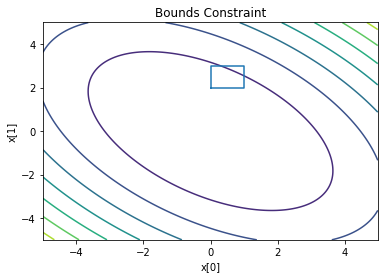

In [106]:
fig, ax = plt.subplots()
plt.ylim(-5,5)
ax.contour(x0_a,x1_a,f([x0_a,x1_a]))
ax.plot([0,0,1,1,0],[2,3,3,2,2],label='Bounds')

ax.set_title('Bounds Constraint')
ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')

In [13]:
# create bounds object array of lower limits then array of upper limits
bounds=optimize.Bounds([0,2],[1,3])
result_bounds=optimize.minimize(f,[1.5,1.5],bounds=bounds)
print(result_bounds)

      fun: 4.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.99999999, 3.99999998])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 1
   status: 0
  success: True
        x: array([0., 2.])


<div id="linear_trustconstr" />

### Linear constraints for `trust-constr`

Note: `trust-constr` requires gradient and hessian
Linear constraints take the general form:
$$
n_{lower} < \vec{A} \cdot \vec{x} < n_{upper}
$$

While I might think of a constraint in a form like this example:
$$
2 x_0 +3 <x_1
$$
as I can then graphically imagine "`x[1]` is restricted to be above this line".  But I can move it into a form that looks like the general form:
$$
-\infty < 2 x_0 - 1 x_1 < -3
$$

I will also use a second linear constraint, with a geometric form of 
$$
x_1 < \frac{1}{3} x_0
$$
and a constraint form of
$$
0 < x_0 + 3 x_1 < \infty
$$

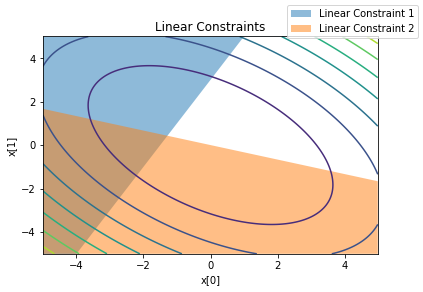

In [143]:
fig, ax = plt.subplots()
plt.ylim(-5,5)
ax.contour(x0_a,x1_a,f([x0_a,x1_a]))
ax.fill_between(x0,2*x0+3,5,alpha=0.5,label='Linear Constraint 1')
ax.fill_between(x0,-1/3*x0,-5,alpha=0.5,label='Linear Constraint 2')

ax.set_xlabel('x[0]')
ax.set_ylabel('x[1]')
ax.set_title('Linear Constraints')
fig.legend()

In [114]:
n_lower1=-np.inf
n_upper1=-3
A1=[-1,2]

linear_constraint = optimize.LinearConstraint(A1,n_lower1,n_upper1)

We can input two constraints at the same time by combining each input in an array:

In [115]:
n_lower2=0
n_upper2=np.inf
A2=[-3,1]

linear_constraint2= optimize.LinearConstraint([A1,A2],[n_lower1,n_lower2],
                                             [n_upper1,n_upper2])

We then pass the linear constraint object to `minimize` via the `constraint` parameter:

In [145]:
result_linearconstraint=optimize.minimize(f,[2,0],
                    method='trust-constr',jac=df,hess=d2f,
                  constraints=linear_constraint)
print(result_linearconstraint.message)

`gtol` termination condition is satisfied.


<div id="nonlinear_trustconstr" />

#### Non-linear Constraint in `trust-constr`
Nonlinear constraints objects fall into the form:
$$
n_{lower} < c(x) < n_{upper}
$$

Here, we use the concrete example:
$$
-\infty < x_0^2 +2 x_0 - x_1 < -1
$$
Where we could also write our constraint as
$$
(x_0 + 1)^2 < x_1
$$
We can graphically see what this example looks like:

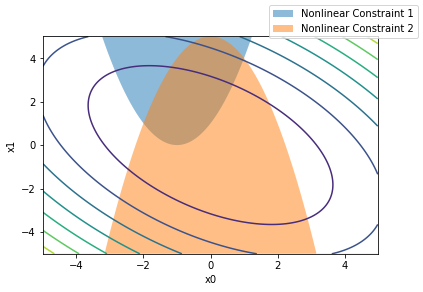

In [148]:
fig, ax = plt.subplots()
plt.ylim(-5,5)
ax.contour(x0_a,x1_a,f([x0_a,x1_a]))
ax.fill_between(x0,(x0+1)**2,5,alpha=0.5,label='Nonlinear Constraint 1')
ax.fill_between(x0,-x0**2+5,-5,alpha=0.5,label='Nonlinear Constraint 2')

ax.set_xlabel('x0')
ax.set_ylabel('x1')
fig.legend()

We create a nonlinear constraint object in much the same way that we created a linear constraint object.

In [118]:
n_lower1=-np.inf
n_upper1= -1

c1 = lambda x : x[0]**2 - 2* x[0] - x[1]

nonlinear_constraint=optimize.NonlinearConstraint(c1,n_lower1,n_upper1)

If we want to add two or more constraints to the same system, we use arrays to combine them into the same input

Let's add

$$
x_1 < -x_0^2+ 5
$$
$$
-5 < -x_0^2 - x_1 < \infty
$$

In [119]:
n_lower2=-5
n_upper2=np.inf

c2 = lambda x : -x[0]**2 - x[1]

nonlinear_constraint2=optimize.NonlinearConstraint([c1,c2],[n_lower1,n_lower2],[n_upper1,n_upper2])

Again just like a linear constraint, we pass this object to `constraint`:

In [120]:
result_nonlinearconstraint=optimize.minimize(f,[2,0],method='trust-constr',jac=df,hess=d2f,
                  constraints=nonlinear_constraint)
print(result_nonlinearconstraint.message)

`gtol` termination condition is satisfied.


In [123]:
result_2constraints=optimize.minimize(f,[2,0],method='trust-constr',jac=df,hess=d2f,
                  constraints=[linear_constraint,nonlinear_constraint])
print(result_2constraints.message)

The maximum number of function evaluations is exceeded.


Enforcing nonlinear constraints uses the gradient and hessian.  Just like for the general functions, the derivatives for the constraints can be provided and the method of calculation can be controlled.

<div id="constraint_SLSQP" />

#### Constraints in SLSQP

Used for SLSQP

Equality constraint
$$
c(x) = 0 
$$

Inequality Constraint
$$
c(x) \geq 0
$$

In [100]:
c = lambda x : -(x[0]-1)**2 + x[1] 

eq_cons= {'type':'ineq',
            'fun': [c,c2]}

In [99]:
c([x0_a,x1_a])>0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [92]:
optimize.minimize(f,[1,1],method='SLSQP',constraints=ineq_cons)

     fun: 0.0
     jac: array([1.49011612e-08, 1.49011612e-08])
 message: 'Optimization terminated successfully.'
    nfev: 9
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0., 0.])